# Fine-tuning a language model

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
import numpy as np
from evaluate import load
import torch

In [2]:
# Yelp Review data
dataset = load_dataset("yelp_review_full")

In [3]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [4]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
# Create small training and evaluation sets
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))


In [6]:


# Load the pretrained BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-uncased-sentiment", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:

# Metric - Accuracy
accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

# Initializing the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [8]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.142848,0.531000
2,No log,0.958671,0.592000
3,No log,0.960508,0.599000


TrainOutput(global_step=375, training_loss=1.0517815755208333, metrics={'train_runtime': 422.5052, 'train_samples_per_second': 7.101, 'train_steps_per_second': 0.888, 'total_flos': 789354427392000.0, 'train_loss': 1.0517815755208333, 'epoch': 3.0})

In [9]:
# Evaluate the model after training
trainer.evaluate()

{'eval_loss': 0.9605082869529724,
 'eval_accuracy': 0.599,
 'eval_runtime': 35.6936,
 'eval_samples_per_second': 28.016,
 'eval_steps_per_second': 3.502,
 'epoch': 3.0}

# Inferencing with the fine-tuned language model

In [10]:
reviews = [
    "Let this review be your reason to visit. We were celebrating my birthday this evening, and I was so happy to share my favorite meals that remind me of home with my American friends. Everyone at the table loved the food. Excellent and attentive service complemented incredible food. I am so grateful for every person who works at Nene’s.",
    "First time having Ukrainian food! It was delicious, but we waited about 1h20min for our entrees. I think that discourages me a bit to come back soon, despite the great food and atmosphere. I would still recommend this place.",
    "In the evening the establishment was full, but we were served quickly enough, the waiter was very nice and quite attentive). Of all the dishes I liked the kharcho soup, very tasty). Pancakes with cottage cheese are tasty, but a little undercooked). Khachapuri is not tasty at all, as if it came from frozen. The dough is hard, there is not enough cheese. Draniki are half raw. Pkhali are not similar to pkhali.",
    "Little bit disappointed. The food tastes good. Nice aromatic seasonings. Food processing time is heavily diversified Ajaruli Khachapuri was burned and cheese was hard. Might be it was warmed up second time in the oven. Pic is included. Khinkali was good.",
    "Today we were served rotten fish on potato pancakes. The fish smelled terrible. Never in 9 years in the United States have I been served rotten fish. We were with a small child, I can’t even imagine what would have happened to the child if he had eaten rotten fish. This would be our third time at the restaurant. Service is always great, food is mediocre. . . but, guys, rotten fish, seriously? I wanted to support this restaurant because the idea is amazing, but after today I can’t."
]


In [11]:
# The trained model is accessed from the trainer
model = trainer.model

# Tokenize the reviews
tokenized_reviews = tokenizer(reviews, padding=True, truncation=True, return_tensors="pt")



In [12]:
model = model.cuda()

tokenized_reviews = tokenized_reviews.to('cuda')

# Perform inference
model.eval() # Set the model to evaluation mode

with torch.no_grad():
    outputs = model(**tokenized_reviews)
    predictions = torch.argmax(outputs.logits, dim=1)

# Convert predictions to list for easy viewing
predicted_ratings = predictions.cpu().tolist()

# Print the predicted ratings
for review, rating in zip(reviews, predicted_ratings):
    print(f"Review: {review}\nPredicted Rating: {rating}\n")

Review: Let this review be your reason to visit. We were celebrating my birthday this evening, and I was so happy to share my favorite meals that remind me of home with my American friends. Everyone at the table loved the food. Excellent and attentive service complemented incredible food. I am so grateful for every person who works at Nene’s.
Predicted Rating: 4

Review: First time having Ukrainian food! It was delicious, but we waited about 1h20min for our entrees. I think that discourages me a bit to come back soon, despite the great food and atmosphere. I would still recommend this place.
Predicted Rating: 2

Review: In the evening the establishment was full, but we were served quickly enough, the waiter was very nice and quite attentive). Of all the dishes I liked the kharcho soup, very tasty). Pancakes with cottage cheese are tasty, but a little undercooked). Khachapuri is not tasty at all, as if it came from frozen. The dough is hard, there is not enough cheese. Draniki are half 

# Fine-tuning a vision transformer

In [13]:
import torch
import numpy as np

from datasets import load_dataset, load_metric
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import DefaultDataCollator, ViTForImageClassification, TrainingArguments, Trainer
from evaluate import load

In [14]:
# Loading the Food101 dataset
food = load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)

# Creating label dictionaries
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label


In [15]:
# Load the image processor for ViT
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

# Image transformation
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

# Preprocessing function
def transforms(examples):
    if "image" in examples:
        examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
        del examples["image"]
    return examples


# Apply preprocessing
food = food.with_transform(transforms)

In [16]:
data_collator = DefaultDataCollator()

# Define the model
model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label
)

# Define Training Arguments
vision_training_args = TrainingArguments(
    output_dir="./vit_food101_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,  # Adjust based on your GPU memory
    per_device_eval_batch_size=8,   # Adjust based on your GPU memory
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# Metric - Accuracy
accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

# Initialize Trainer
vision_trainer = Trainer(
    model=model,
    args=vision_training_args,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Fine-tune the model
vision_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.534100,0.601970,0.897000
2,0.375700,0.370031,0.905000
3,0.216000,0.323047,0.919000


TrainOutput(global_step=1500, training_loss=0.7086004994710287, metrics={'train_runtime': 553.8309, 'train_samples_per_second': 21.667, 'train_steps_per_second': 2.708, 'total_flos': 9.307289843712e+17, 'train_loss': 0.7086004994710287, 'epoch': 3.0})

In [18]:
# Evaluate the model after training
vision_trainer.evaluate()

{'eval_loss': 0.31369879841804504,
 'eval_accuracy': 0.929,
 'eval_runtime': 17.5373,
 'eval_samples_per_second': 57.021,
 'eval_steps_per_second': 7.128,
 'epoch': 3.0}

#  Inference with the fine-tuned vision model

In [19]:
import matplotlib.pyplot as plt
from PIL import Image

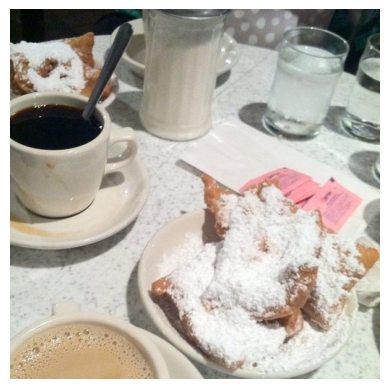

Image Index: 0, Predicted Class: beignets


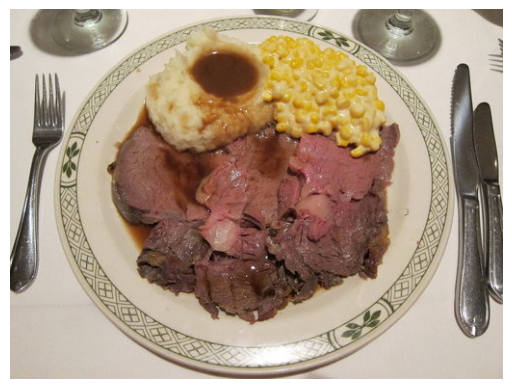

Image Index: 299, Predicted Class: prime_rib


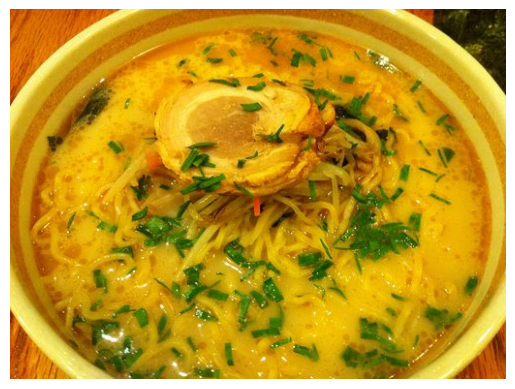

Image Index: 599, Predicted Class: ramen


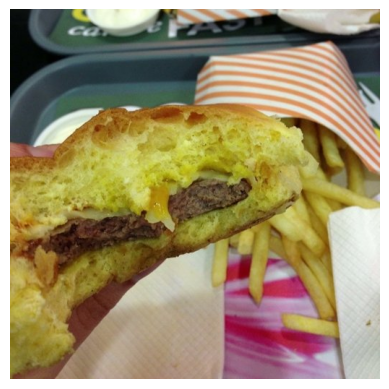

Image Index: 899, Predicted Class: hamburger


In [20]:
# Load the validation dataset
ds = load_dataset("food101", split="validation[:1000]")

# Loading model
fine_tuned_model = vision_trainer.model

fine_tuned_model = fine_tuned_model.cuda()

# Selected indices for inference
indices = [0, 299, 599, 899]

# Preprocess and perform inference
for idx in indices:
    # Original image
    image = ds[idx]["image"]
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Preprocess the image
    processed_image = _transforms(image.convert("RGB")).unsqueeze(0).cuda()


    # Model inference
    fine_tuned_model.eval()
    with torch.no_grad():
        outputs = fine_tuned_model(processed_image)
        prediction = torch.argmax(outputs.logits, dim=1)

    # Get the predicted class
    predicted_class = id2label[str(prediction.item())]
    print(f"Image Index: {idx}, Predicted Class: {predicted_class}")
